# Pull in data from Seattle Public Library

This notebook also creates the figure comparing the publication dates between public library books and LFL books.
It also sets up the data files with the percent fiction and percent juvenile books per library branch.

In [1]:
#import the required libraries
import os
import csv
import requests
import json as json
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import matplotlib.pyplot as plt
#is this needed?
%matplotlib inline 
from matplotlib import cm
import seaborn as sns


## The following are api calls that provide some useful information

In [ ]:
#Counts the number of books from 11/1/2019. Over 1.4 million
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=count(BibNum)&reportdate=2019-11-01T00:00:00.000
#get list of neighborhoods
https://data.seattle.gov/resource/6vkj-f5xf.json?$query=select distinct ItemLocation
#See number by a neightborhood
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=count(BibNum)&ItemLocation=cen
#I think we need: col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm (Madrona Sally Goaldman for central).
#None in Laurelhusrt
#This returns counts by location:
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation

#Not sure if this works    
https://data.seattle.gov/resource/6vkj-f5xf.json?$query=select count(BibNum) where ItemLocation=col OR ItemLocation=mon
    
    

## Skip to Analysis if you have files already

## Open json file

In [2]:
#Open up the files for reading
with open("SPL-bibCOUNTS-May2019.json", "r") as read_file: #Replace this with the filename of your choice
    jmay = json.load(read_file)
with open("SPL-bibCOUNTS-July2019.json", "r") as read_file: #Replace this with the filename of your choice
    jjuly = json.load(read_file)


## Get the number of books in branches


In [21]:
#This gets the recent ones for the neighborhoods and the date
coldate1 = '"2019-05-01T00:00:00.000"'
coldate2 = '"2019-07-01T00:00:00.000"'
may=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$where=reportdate='+coldate1+'&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets
july=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$where=reportdate='+coldate2+'&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets

#THis one gets all:
#r=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets
jmay=json.loads(may.text) #parse the json into a list
jjuly=json.loads(july.text) #parse the json into a list


In [22]:
test = jmay +jjuly
print(len(test))
print(len(jmay))
print(len(jjuly))

65
33
32


In [23]:
#jmay[0]
jjuly[0]


{'ItemLocation': 'col', 'count_BibNum': '32701'}

## Save the json files

In [24]:
with open('SPL-bibCOUNTS-May2019.json', "w") as write_file:
    json.dump(jmay, write_file)
with open('SPL-bibCOUNTS-July2019.json', "w") as write_file:
    json.dump(jjuly, write_file)

## Get the count of books in your branches


In [39]:
#OLD data collection: col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm
#Better update: col, mon, qna, gwd, nga, net, mgm and dth (these two are for Central)
#Just to have the data, get net for May to compare with Laurelhurst
mayhoods = jmay #create a json file to mess with
julyhoods = jjuly

branches1=[] #dim list as a empty list

for c in mayhoods:  #d is the dictionary of parsed json
        if c['ItemLocation']=='col':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='mgm':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='dth':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='qna':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='gwd':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='nga':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='net': #This is for laurelhurst
            branches1.append(c['count_BibNum'])

            
branches2=[] #dim list as a empty list

for c in julyhoods:  #d is the dictionary of parsed json
        if c['ItemLocation']=='net': #This is for Ravenna
            branches2.append(c['count_BibNum'])
        if c['ItemLocation']=='mon':
            branches2.append(c['count_BibNum'])

print("List built:", len(branches1),"elements") #print how many elements are in lists
print("List built:", len(branches2),"elements")

List built: 7 elements
List built: 2 elements


In [40]:
#Convert the dictionary to a dataframe
bibctsmay = pd.DataFrame(branches1, columns=['bibcount'])
bibctsmay = pd.to_numeric(bibctsmay['bibcount'])

bibctsjuly = pd.DataFrame(branches2, columns=['bibcount'])
bibctsjuly = pd.to_numeric(bibctsjuly['bibcount'])

print(bibctsmay.head(10))
print(bibctsjuly.head(10))


0    31488
1    34276
2    51710
3    48137
4    23893
5    60289
6    10226
Name: bibcount, dtype: int64
0    16425
1    60672
Name: bibcount, dtype: int64


In [41]:
#This is needed to get the totals for the next part which is gathering the actual data
maybooks=bibctsmay.sum()
julybooks=bibctsjuly.sum()
print(maybooks)
print(julybooks)

260019
77097


# Retrieve Recent Records

### Open previous json if alread gathered, then skip to create CSV

In [3]:
#Open up the file for reading (this file location is on a harddrive because it's too big to push to GitHub)
with open("C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-Study-Data.json", "r") as read_file: #Replace this with the filename of your choice
    alldata = json.load(read_file)
count=len(alldata)
count

337116

## Collect the data

In [43]:
#This works in browser: https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= 'col' or ItemLocation='mon' or ItemLocation='qna' or ItemLocation='gwd' or ItemLocation='mgm' or ItemLocation='nga' or ItemLocation='uni' or ItemLocation='net' and reportdate='2019-11-01T00:00:00.000'&$limit=
#This gets the recent ones and limits the number to what was calculated above
s=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= "col" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="qna" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="gwd" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="mgm" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="nga" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="net" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="dth" and reportdate="2019-05-01T00:00:00.000"&$limit='+str(maybooks)) #build string according to SOCRATA's convention to get public data assets
t=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= "mon" and reportdate="2019-07-01T00:00:00.000" or ItemLocation="net" and reportdate="2019-07-01T00:00:00.000"&$limit='+str(julybooks)) #build string according to SOCRATA's convention to get public data assets

#Check this: https://stackoverflow.com/questions/42078161/python-appending-json-object-to-exisiting-json-object

#THis one gets all:
#r=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets


l=json.loads(s.text)
m=json.loads(t.text)
alldata= l + m
print(len(alldata))


337116


## Save the json file

In [44]:
with open('SPL-Study-Data.json', "w") as write_file:
    json.dump(alldata, write_file)

# Create CSV
dataframe created by transforming the alldata json file

#### Skip this if CSV is already created

In [45]:
metadata=open('SPL-Study-Data.csv', 'w', newline='', encoding='utf-8')
csv.writer(metadata).writerow(['bibnum','title','author','isbn','reportdate','publicationyear','itemtype','itemcollection','itemlocation'])

for i in alldata:
    csv.writer(metadata).writerow([i['bibnum'],
        i.get('title'),
        i.get('author'),
        i.get('isbn'),
        i.get('reportdate'),
        i.get('publicationyear'),
        i.get('itemtype'),
        i['itemcollection'],
        i['itemlocation']])                                  
        #i.get('isbn'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'.
                                   

metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf-8 error.  But here cp1252 produces an error!
df = pd.read_csv('SPL-Study-Data.csv',encoding='utf-8')

print('The resulting dataframe has',len(df),'rows')

The resulting dataframe has 337116 rows


In [46]:
df.head(1)

,bibnum,title,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation
0,2680854,Towers of midnight / Robert Jordan and Brandon...,"Jordan, Robert, 1948-2007","0765325942, 9780765325945",2019-05-01T00:00:00.000,2010.,acbk,nasf,dth


In [2]:
#Open previously created csv file if needed:
#This is raw data
df = pd.read_csv('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-Study-Data.csv',encoding='utf-8')

## Open data dictionary file to map fiction/nonfiction and media type

In [3]:
#Get the datadictionary
dftype = pd.read_csv('SPL-datadict-type.csv',encoding='utf-8')
dftype.head(2)

,itemtype,format
0,acart,Art
1,acphoto,Art


In [4]:
#Create a new dataframe with the data dictionary info type. Inner join is intersection so removes rows with no partner in other dataframe
dfall = pd.merge(df, dftype, on='itemtype', how='inner')

In [5]:
dfcol = pd.read_csv('SPL-datadict-collection.csv',encoding='utf-8')
dfcol.head(2)

,itemcollection,type
0,ncenf,Nonfiction
1,cabob,NaN


In [6]:
#Create a new dataframe with the data dictionary info collection. Inner join is intersection so removes rows with no partner in other dataframe
dfall = pd.merge(dfall, dfcol, on='itemcollection', how='inner')

In [7]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337116 entries, 0 to 337115
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   bibnum           337116 non-null  int64 
 1   title            337115 non-null  object
 2   author           290629 non-null  object
 3   isbn             297979 non-null  object
 4   reportdate       337116 non-null  object
 5   publicationyear  336805 non-null  object
 6   itemtype         337116 non-null  object
 7   itemcollection   337116 non-null  object
 8   itemlocation     337116 non-null  object
 9   format           337094 non-null  object
 10  type             336556 non-null  object
dtypes: int64(1), object(10)
memory usage: 30.9+ MB


## Pare down to books

In [9]:
dfbook = dfall.loc[(dfall['format']=='Book') | (dfall['format']=='Audiobook Disc')]
#adding in the audiobook disc adds 13 items to the list. LFL list includes audio books.

In [10]:
dfbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279696 entries, 0 to 337100
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   bibnum           279696 non-null  int64 
 1   title            279696 non-null  object
 2   author           267360 non-null  object
 3   isbn             277534 non-null  object
 4   reportdate       279696 non-null  object
 5   publicationyear  279451 non-null  object
 6   itemtype         279696 non-null  object
 7   itemcollection   279696 non-null  object
 8   itemlocation     279696 non-null  object
 9   format           279696 non-null  object
 10  type             279511 non-null  object
dtypes: int64(1), object(10)
memory usage: 25.6+ MB


## Add neighborhood column

In [11]:
dfhood = pd.read_csv('neighborhoods.csv',encoding='utf-8')
dfhood.head(2)

,itemlocation,reportdate,neighborhood,count
0,col,2019-05-01T00:00:00.000,Columbia City,1
1,mon,2019-07-01T00:00:00.000,Montlake,1


In [12]:
#Create a new dataframe with the neighborhood info. Inner join is intersection so removes rows with no partner in other dataframe
#Laurelhurst needs data from net in may, Ravenna from net in July, that's why reportdate is needed
dfbook = pd.merge(dfbook, dfhood, on=['itemlocation', 'reportdate'], how='inner')

In [13]:
dfbook.itemtype.unique()

array(['acbk', 'jcbk', 'bcbk', 'ucunkn', 'arbk', 'jrbk', 'pkbknh', 'ahbk',
       'ucunknj', 'jrmus', 'jcmus', 'bccd'], dtype=object)

# Clean book data

## Deal with the book year data issues

In [14]:
#Get a csv of the unique year values to look at problem values
dfyears = dfbook.publicationyear.unique()
dfyears = pd.DataFrame(dfyears)
dfyears.to_csv('SPLyears.csv', mode = 'w', index=False)

In [15]:
#Make sure all values are string (?) then get rid of all '[c', 'Â©' and then the rest of the brackets 
dfbook['publicationyear']= dfbook['publicationyear'].astype(str)
dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('[c',''),'')
#dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('Â©',''),'')
dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('[','').replace(']','')) 
#dfbook['publicationyear'] = preg_replace("/(©|&copy;|&#169;)/", "", dfbook['publicationyear'])
#dfbook['publicationyear'] = str_replace(array('©'), array(''), dfbook['publicationyear'])

In [16]:
#Create csv file to look at what date problems are left
#The cleaning seems to do a very good job.  Any blanks appear to be blank at SPL too.
dfbook.to_csv('SPL-book-data-cleaned.csv', mode = 'w', index=False)

In [17]:
#The year values are very difficult- lots of non numeric characters.
#Use: https://realpython.com/python-data-cleaning-numpy-pandas/#combining-str-methods-with-numpy-to-clean-columns

#reg expression: r'^(\d{4})'  This takes the first four numeric digits.  Everything else goes to NaN
dfbook['publicationyear'] = dfbook['publicationyear'].str.extract(r'^(\d{4})', expand=False)
dfbook.head()

,bibnum,title,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count
0,2680854,Towers of midnight / Robert Jordan and Brandon...,"Jordan, Robert, 1948-2007","0765325942, 9780765325945",2019-05-01T00:00:00.000,2010,acbk,nasf,dth,Book,Fiction,Central District,1
1,3406187,The city in the middle of the night / Charlie ...,"Anders, Charlie Jane","0765379961, 9780765379962, 9781466871137",2019-05-01T00:00:00.000,2019,acbk,nasf,dth,Book,Fiction,Central District,1
2,3023254,1634 : the Bavarian crisis / Eric Flint and Vi...,"Flint, Eric","1439132763, 9781439132760",2019-05-01T00:00:00.000,2009,acbk,nasf,dth,Book,Fiction,Central District,1
3,3126212,Barsk : the elephants' graveyard / Lawrence M....,"Schoen, Lawrence M.","0765377020, 9780765377029",2019-05-01T00:00:00.000,2015,acbk,nasf,dth,Book,Fiction,Central District,1
4,3284914,Provenance / Ann Leckie.,"Leckie, Ann","031638867X, 9780316388672",2019-05-01T00:00:00.000,2017,acbk,nasf,dth,Book,Fiction,Central District,1


In [20]:
#Convert to numeric and show datatype
dfbook['publicationyear'] = pd.to_numeric(dfbook['publicationyear'])
dfbook['publicationyear'].dtype

dtype('float64')

In [21]:
#What percent are Nan?
dfbook['publicationyear'].isnull().sum() / len(dfbook)

0.018845460785996224

In [22]:
len(dfbook)

279696

In [23]:
#The title and author are stored in the same variable separated by " / ".  Need to split those out.  There is an
#author variable as well but the values are stored in many different formats
#Rename title variable
dfbook.rename({'title': 'titleAuthor'}, axis=1, inplace=True)
#Split out title
dfbook['title'] = dfbook.titleAuthor.str.replace("( / ).*","")
#dfbook.head(1)

In [24]:
#Save csv file.  THIS IS THE WORKING DATAFILE FOR THE REST OF THIS NOTEBOOK
dfbook.to_csv('SPL-dfbook.csv', mode = 'w', index=False)

# ANALSYS
Should have a dfbook dataframe at this point

In [2]:
#Open a previous CSV
dfbook = pd.read_csv('SPL-dfbook.csv',encoding='utf-8')

### Histogram of years

In [29]:
#Open LFL year data
lflyear = pd.read_csv('../bookData/LFL-books-years.csv',encoding='utf-8')
lflyear.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
0,2006,1,0,0,Central District,CentralDistrict6,Fiction,Adult,Novel,Null,NOV,English,English
1,1992,1,0,0,Montlake,Montlake4,Nonfiction,Adult,Self Help/Health,Null,SH,English,English
2,1999,1,1,0,Phinney-Greenwood,Phinney-Green4,Fiction,Adult,Novel,Null,NOV,English,English
3,2014,1,0,0,Montlake,Montlake4,Fiction,Adult,Mystery,Null,MYS,English,English
4,2017,1,0,0,Northgate,Northgate5,Fiction,Adult,Mystery,Null,MYS,English,English


In [30]:
lflyear['count'].sum()

1013

In [31]:
#Earliest year
dftemp = dfbook.sort_values(by='publicationyear', ascending=True).reset_index()
dftemp.head(1)

,index,bibnum,titleAuthor,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count,title
0,19441,952642,The religious instruction of the Negroes in th...,"Jones, Charles Colcock, 1804-1863",NaN,2019-05-01T00:00:00.000,1842.0,acbk,naaanf,dth,Book,Nonfiction,Central District,1,The religious instruction of the Negroes in th...


In [32]:
#Set up a dataset with years going back as far as LFLs- Want to compare apples to apples
dfbookyr = dfbook.loc[dfbook['publicationyear']>1927]
print("Original:",len(dfbook)," New dataset:",len(dfbookyr))
dfbookyr.head()

Original: 279696  New dataset: 274376


,bibnum,titleAuthor,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count,title
0,2680854,Towers of midnight / Robert Jordan and Brandon...,"Jordan, Robert, 1948-2007","0765325942, 9780765325945",2019-05-01T00:00:00.000,2010.0,acbk,nasf,dth,Book,Fiction,Central District,1,Towers of midnight
1,3406187,The city in the middle of the night / Charlie ...,"Anders, Charlie Jane","0765379961, 9780765379962, 9781466871137",2019-05-01T00:00:00.000,2019.0,acbk,nasf,dth,Book,Fiction,Central District,1,The city in the middle of the night
2,3023254,1634 : the Bavarian crisis / Eric Flint and Vi...,"Flint, Eric","1439132763, 9781439132760",2019-05-01T00:00:00.000,2009.0,acbk,nasf,dth,Book,Fiction,Central District,1,1634 : the Bavarian crisis
3,3126212,Barsk : the elephants' graveyard / Lawrence M....,"Schoen, Lawrence M.","0765377020, 9780765377029",2019-05-01T00:00:00.000,2015.0,acbk,nasf,dth,Book,Fiction,Central District,1,Barsk : the elephants' graveyard
4,3284914,Provenance / Ann Leckie.,"Leckie, Ann","031638867X, 9780316388672",2019-05-01T00:00:00.000,2017.0,acbk,nasf,dth,Book,Fiction,Central District,1,Provenance


(1900.0, 2020.0)

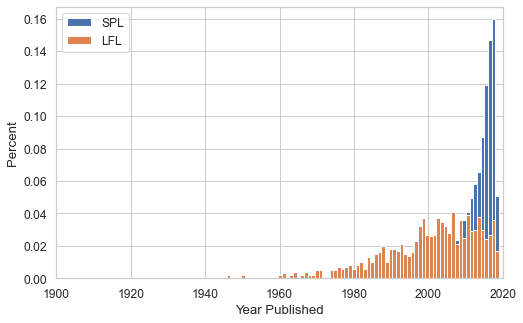

In [33]:
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

#SPL
p1= sns.distplot(
    dfbookyr['publicationyear'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')
#LFL
p1= sns.distplot(
    lflyear['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['SPL','LFL'])
plt.xlim(1900, 2020)

(1960.0, 2020.0)

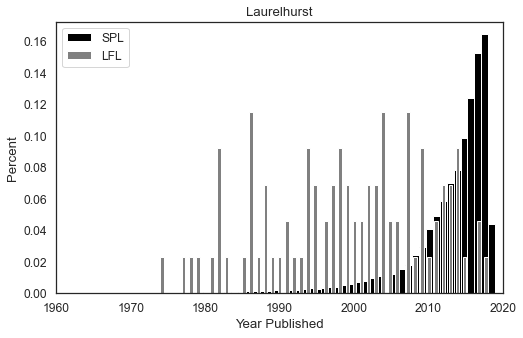

In [34]:
# BY NEIGHBORHOOD
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

hood = "Laurelhurst"

#dfbookyrcol = dfbookyr[dfbookyr['itemlocation']=='col']
dfbookyrcol = dfbookyr[dfbookyr['neighborhood']==hood]
lflyearcol = lflyear[lflyear['neighborhood']==hood]


#SPL
p1= sns.distplot(
    dfbookyrcol['publicationyear'], norm_hist=True, kde=False, bins=92, color='black', hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')
#LFL
p1= sns.distplot(
    lflyearcol['yrpub'], norm_hist=True, kde=False, bins=92, color = 'gray', hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['SPL','LFL'])
plt.title(hood)
plt.xlim(1960, 2020)

In [35]:
dfbookyr.neighborhood.unique()

array(['Central District', 'Phinney-Greenwood', 'Queen Anne',
       'Laurelhurst', 'Northgate', 'Columbia City', 'Ravenna', 'Montlake'],
      dtype=object)

In [36]:
hoods = pd.DataFrame(dict(neighborhood=dfbookyr.neighborhood.unique()))
hoods = hoods.sort_values(by=['neighborhood'])
hoods.head()


,neighborhood
0,Central District
5,Columbia City
3,Laurelhurst
7,Montlake
4,Northgate


In [37]:
for h in hoods['neighborhood']:
    hood=h
    print(hood)


Central District
Columbia City
Laurelhurst
Montlake
Northgate
Phinney-Greenwood
Queen Anne
Ravenna


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

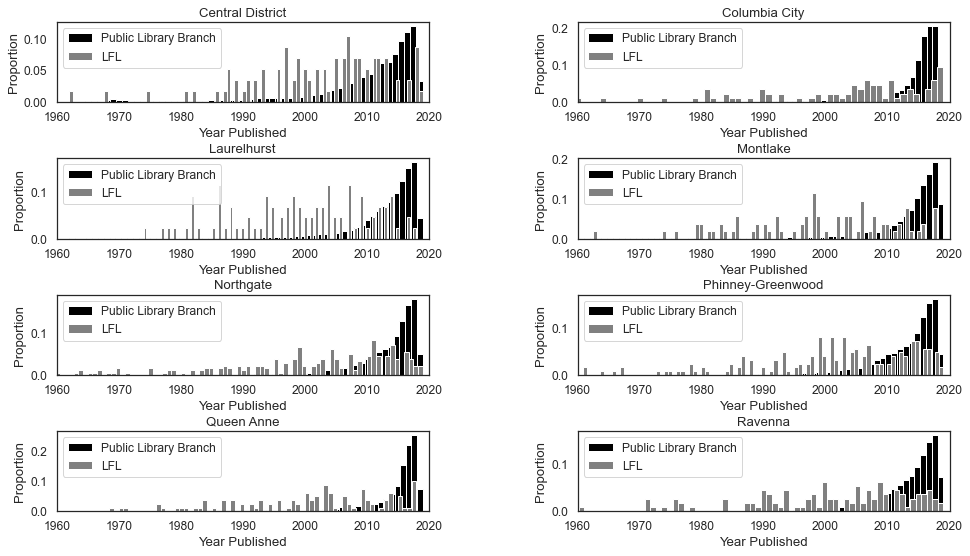

In [38]:
# BY NEIGHBORHOOD
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [16, 5]})

plt.rcParams["figure.figsize"] = [16,9]

# create a color palette
palette = plt.get_cmap('tab20b')

fig = plt.figure()
fig.subplots_adjust(hspace=0.7, wspace=0.4)

num=0
for h in hoods['neighborhood']:
    hood = h    
    dfbookyrcol = dfbookyr[dfbookyr['neighborhood']==hood]
    lflyearcol = lflyear[lflyear['neighborhood']==hood]
    
    num+=1
    plt.subplot(4,2, num)
    
    #SPL
    p1= sns.distplot(
        dfbookyrcol['publicationyear'], norm_hist=True, kde=False, bins=92, color="black", hist_kws={"alpha": None}).set(xlabel='Year Published', ylabel='Proportion')
    #LFL
    p1= sns.distplot(
        lflyearcol['yrpub'], norm_hist=True, kde=False, bins=92, color="gray", hist_kws={"alpha": None}).set(xlabel='Year Published', ylabel='Proportion') 

    plt.legend(labels=['Public Library Branch','LFL'])
    plt.title(hood)
    plt.xlim(1960, 2020)

#Save figure 
plt.savefig('../figures/pub-dates-comparison.eps')


### Calculate Cumulative Percentage
This is used to see what year and above represents 90% of the books

#### SPL

In [39]:
#Groups by pub year 
dfSPLyr = dfbook.groupby(['publicationyear'])['count'].sum().reset_index() #total of each category
#Sort high to low
dfSPLyr = dfSPLyr.sort_values(by='publicationyear', ascending=False).reset_index()

In [40]:
dfSPLyr['cumulative']=dfSPLyr['count'].cumsum()/dfSPLyr['count'].sum()
dfSPLyr.head(20)

,index,publicationyear,count,cumulative
0,114,2019.0,13687,0.049875
1,113,2018.0,43310,0.207696
2,112,2017.0,39947,0.353262
3,111,2016.0,32406,0.471349
4,110,2015.0,23696,0.557697
5,109,2014.0,17863,0.622789
6,108,2013.0,15833,0.680485
7,107,2012.0,13403,0.729325
8,106,2011.0,11109,0.769806
9,105,2010.0,9671,0.805047


#### LFL

In [41]:
#Create new dataframe
dfLFLyr=lflyear

In [42]:
#Groups by pub year 
dfLFLyr = dfLFLyr.groupby(['yrpub'])['count'].sum().reset_index() #total of each category
#Sort high to low
dfLFLyr = dfLFLyr.sort_values(by='yrpub', ascending=False).reset_index()

In [43]:
total = dfLFLyr['count'].sum()
print(total)

1013


In [44]:
dfLFLyr['cumulative']=dfLFLyr['count'].cumsum()/dfLFLyr['count'].sum()
dfLFLyr.head(40)

,index,yrpub,count,cumulative
0,67,2019,17,0.016782
1,66,2018,36,0.052320
2,65,2017,27,0.078973
3,64,2016,24,0.102665
4,63,2015,30,0.132280
5,62,2014,38,0.169793
6,61,2013,30,0.199408
7,60,2012,29,0.228036
8,59,2011,39,0.266535
9,58,2010,25,0.291214


# Set up a dataframe with SPL data by neighborhood
fiction/nonfiction, percent children

In [45]:
dfbook.type.unique()

array(['Fiction', 'Nonfiction', 'Language', 'Reference', nan],
      dtype=object)

### Percent Fiction

In [46]:
#Set up a dataframe with the percent fiction

#Groups count by Neighborhood, and type, calculates percent
bksfiction = dfbook.groupby(['neighborhood', 'type'])['count'].sum().reset_index() #total of each category
bksfiction['total'] = bksfiction.groupby('neighborhood')['count'].transform('sum') #Inserts total count for the neighborhood for each type in each neighborhood 
bksfiction['percent'] = bksfiction['count']/bksfiction['total']


#Select fiction
fic = bksfiction.loc[bksfiction['type']=='Fiction']
fic.head(8)

,neighborhood,type,count,total,percent
0,Central District,Fiction,23003,49029,0.469171
4,Columbia City,Fiction,14870,26486,0.561429
8,Laurelhurst,Fiction,29836,50942,0.585686
12,Montlake,Fiction,7731,13001,0.594647
15,Northgate,Fiction,16174,27569,0.586673
19,Phinney-Greenwood,Fiction,22772,42934,0.530395
23,Queen Anne,Fiction,10197,18491,0.551457
27,Ravenna,Fiction,29569,51059,0.579114


In [47]:
fictionbks = fic['count'].sum()
totalbks = fic['total'].sum()
perfic = fictionbks/totalbks
print(perfic)

0.551506023018772


In [48]:
test = dfbook.copy()
test['age'] = dfbook['itemtype'].str[:1]


In [49]:
#Save csv file
fic.to_csv('SPL-fiction.csv', mode = 'w', index=False)

### Percent Juvenile

In [50]:
dfbook.itemtype.unique()


array(['acbk', 'jcbk', 'bcbk', 'ucunkn', 'arbk', 'jrbk', 'pkbknh', 'ahbk',
       'ucunknj', 'jrmus', 'jcmus', 'bccd'], dtype=object)

In [51]:
#Set up a dataframe with the juvenile books. Uses the dfbook dataframe saved before analysis

#Groups count by Neighborhood, and itemtype, calculates percent
bksage = dfbook.groupby(['neighborhood', 'itemtype'])['count'].sum().reset_index() #total of each category
bksage['ageletter'] = bksage['itemtype'].str[:1] #selects first letter of itemtype code (a=adult and YA, j=juvenile)
bksagelist = bksage.groupby(['neighborhood','ageletter'])['count'].apply(lambda x : x.astype(int).sum()) #sums up the a's and j's by neighborhood
bksage = pd.DataFrame(bksagelist).reset_index()
bksage['total'] = bksage.groupby('neighborhood')['count'].transform('sum') #Inserts total count for the neighborhood for each type in each neighborhood

bksage['percent'] = bksage['count']/bksage['total']

bksage.head()


,neighborhood,ageletter,count,total,percent
0,Central District,a,28750,49029,0.586388
1,Central District,b,7,49029,0.000143
2,Central District,j,20115,49029,0.410267
3,Central District,p,148,49029,0.003019
4,Central District,u,9,49029,0.000184


In [52]:
#Select juveniles
bksjuv = bksage.loc[bksage['ageletter']=='j']
bksjuv.head(8)


,neighborhood,ageletter,count,total,percent
2,Central District,j,20115,49029,0.410267
7,Columbia City,j,11587,26486,0.437476
11,Laurelhurst,j,23079,50942,0.453045
15,Montlake,j,6266,13006,0.481778
19,Northgate,j,11591,27569,0.420436
23,Phinney-Greenwood,j,18297,42934,0.426166
27,Queen Anne,j,7791,18491,0.421340
31,Ravenna,j,22990,51239,0.448682


In [53]:
#Save csv file
bksjuv.to_csv('SPL-juvenilePercent.csv', mode = 'w', index=False)

## Compare ISBNs

In [54]:
#Open LFL raw book data and open SPL data if needed
dflfl = pd.read_csv('../bookData/bookData.csv')
dfbook = pd.read_csv('SPL-dfbook.csv',encoding='utf-8')

In [55]:
#Pare down to neighborhood and isbn columns
lfl = dflfl[['neighborhood','isbn','yrpub']].copy()
spl = dfbook[['neighborhood','isbn']].copy()

In [56]:
#Convert isbn variable to string
spl['isbn'] = spl['isbn'].astype('str')

In [57]:
#The SPL data has many isbns all in the same column.  Parse them out.
#I got this from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
#First get needed packages 
import numpy as np
from itertools import chain

In [58]:
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = spl['isbn'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
splisbn = pd.DataFrame({'neighborhood': np.repeat(spl['neighborhood'], lens),
                    'isbn': chainer(spl['isbn'])})

In [59]:
#The isbn column has apostrophes and an occasional 'b'. Remove them
splisbn['isbn'] = splisbn['isbn'].str.replace(r"[b\',]", '')

In [60]:
#Reset the index
splisbn.reset_index(drop=True,inplace=True)

In [62]:
#Merge dataframes to get isbns present in lfl and spl. The new dataframe has a column renamed to splhood that shows a 
#value if the isbn is present at that library branch
shared = pd.merge(lfl, splisbn, on='isbn', how='inner')
shared.rename(columns={"neighborhood_x": "neighborhood", "neighborhood_y": "splhood"}, inplace=True)

In [64]:
#Save file if you want
shared.to_csv('isbn-matching.csv', mode = 'w', index=False)

In [74]:
shared.head()

,neighborhood,isbn,yrpub,splhood
0,Phinney-Greenwood,006243375X,2016,Columbia City
1,Phinney-Greenwood,037378970X,2017,Northgate
2,Ravenna,067989067X,2000,Central District
3,Ravenna,067989067X,2000,Phinney-Greenwood
4,Ravenna,067989067X,2000,Queen Anne


In [65]:
sharedbooks = shared.groupby(['isbn'])['splhood'].count().reset_index()

In [67]:
#Count the branches for each isbn. One book is in all branches and Central District is two branches so 9.
sharedbooks.sort_values(by='splhood', ascending=False, inplace=True)
sharedbooks.head()

,isbn,splhood
29,198480183X,9
14,1501187597,7
2,067989067X,7
7,144248845X,7
25,1641290110,5


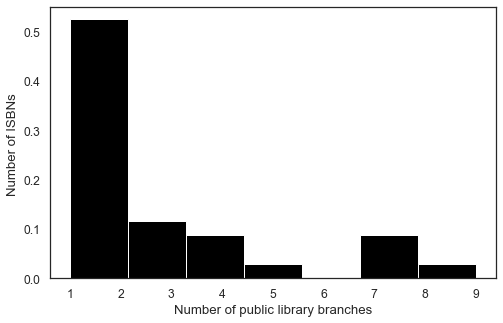

In [68]:
# Histogram of the number of shared ISBNs represented in one or more SPL library branches
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

#SPL
p1= sns.distplot(
    sharedbooks['splhood'], norm_hist=True, kde=False, bins=7, color='black', hist_kws={"alpha": 1}).set(xlabel='Number of public library branches', ylabel='Number of ISBNs ')


In [69]:
#Count isbns that are present in SPL branches
sharedbooks[sharedbooks['splhood']>0].count()

isbn       30
splhood    30
dtype: int64

In [70]:
#See the number of books from LFLs that are available in the study SPL branches
#Since this leaves out all the other branches, it's not really useful. Should just look at direct association
sharedhood= shared[shared['splhood'].notna()].groupby(['splhood']).count().reset_index()
sharedhood.head(8)

,splhood,neighborhood,isbn,yrpub
0,Central District,9,9,9
1,Columbia City,5,5,5
2,Laurelhurst,16,16,16
3,Montlake,6,6,6
4,Northgate,8,8,8
5,Phinney-Greenwood,14,14,14
6,Queen Anne,8,8,8
7,Ravenna,17,17,17


In [73]:
#Count times the LFL books are in the nearby branch. Only five neighborhoods had books in LFLs that were present in the public library branch
samehood= shared[shared['splhood']==shared['neighborhood']].groupby(['splhood']).count().reset_index()
samehood.head(10)

,splhood,neighborhood,isbn,yrpub
0,Laurelhurst,1,1,1
1,Northgate,2,2,2
2,Phinney-Greenwood,2,2,2
3,Queen Anne,1,1,1
4,Ravenna,3,3,3


In [72]:
#See what year the shared books were published
years = shared[shared['splhood']==shared['neighborhood']]
years.head(10)

,neighborhood,isbn,yrpub,splhood
13,Laurelhurst,1335474625,2018,Laurelhurst
17,Ravenna,1338068474,2018,Ravenna
21,Queen Anne,144248845X,2014,Queen Anne
26,Northgate,1472906500,2014,Northgate
36,Northgate,1487001835,2018,Northgate
54,Ravenna,1603093680,2015,Ravenna
56,Ravenna,1606840355,2010,Ravenna
66,Phinney-Greenwood,1641290110,2018,Phinney-Greenwood
75,Phinney-Greenwood,198480183X,2018,Phinney-Greenwood


## todo
9 isbns match. But there are 5 isbns that are duplicates within neiborhood- how many iin same LFL? (look at bookData file in Drive).  How to handle duplicates. Are there really only 30 ISBNs that are shared between LFLs and their local lib?
So, 9 books matched lfl to local spl branch. That means there were 74 other books (out of 83 total) that were in an lfl and in at least one of the study spl branches. If we included all spl branches, there would probably be many other matches. However, what matters here is how easily could someone browse their local spl branch shelves and find a book that is also in a nearby lfl.

## Get all the isbns from May and July to compare

In [8]:
#Use previous json files

#Get count of all SPL isbns for May
with open("SPL-bibCOUNTS-May2019.json", "r") as read_file: 
    may = json.load(read_file)

maylist=[]
for c in may:  
            maylist.append(c['count_BibNum'])

#Get count of all SPL isbns for July 
with open("SPL-bibCOUNTS-July2019.json", "r") as read_file: 
    july = json.load(read_file)

julylist=[]
for c in july:  
            julylist.append(c['count_BibNum'])
        
#Convert the dictionaries to a dataframes
bibctsMay = pd.DataFrame(maylist, columns=['bibcount'])
bibctsMay = pd.to_numeric(bibctsMay['bibcount'])

bibctsJuly = pd.DataFrame(julylist, columns=['bibcount'])
bibctsJuly = pd.to_numeric(bibctsJuly['bibcount'])

#Sum the lists
bibMay = bibctsMay.sum()
bibJuly = bibctsJuly.sum()

print("May ISBNs: ", bibMay, " July ISBNs: ", bibJuly)

May ISBNs:  1324806  July ISBNs:  1486646


In [11]:
#Get isbns from SPL-
#Dates of data:
coldate1 = '"2019-05-01T00:00:00.000"'
coldate2 = '"2019-07-01T00:00:00.000"'

Collect data
s=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=isbn&$where=reportdate='+coldate1+'&$limit='+str(bibMay)) 
m=json.loads(s.text)

t=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=isbn&$where=reportdate='+coldate2+'&$limit='+str(bibJuly)) 
j=json.loads(t.text)
               
print(len(m)," ",len(j))

1324806   1486646


In [12]:
#Save the files
with open('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-may2019-isbns.json', "w") as write_file:
    json.dump(m, write_file)
with open('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-july2019-isbns.json', "w") as write_file:
    json.dump(j, write_file)

In [13]:
#Create a dataframe for spl data and combine the json files- There are blank entries in here.
metadata=open('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-isbn.csv', 'w', newline='', encoding='utf-8')
csv.writer(metadata).writerow(['isbn'])

for i in m:
    csv.writer(metadata).writerow([i])

for i in j:
    csv.writer(metadata).writerow([i])
  
metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe.
splallisbn = pd.read_csv('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-isbn.csv',encoding='utf-8')

In [ ]:
#Convert isbn variable to string
splallisbn['isbn'] = splallisbn['isbn'].astype('str')

In [23]:
#The SPL data has many isbns all in the same column.  Parse them out.
#I got this from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
#First get needed packages 
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = splallisbn['isbn'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
splallisbn2 = pd.DataFrame({'isbn': chainer(splallisbn['isbn'])})

#The isbn column has apostrophes and an occasional 'b'. Remove them
splallisbn2['isbn'] = splallisbn2['isbn'].str.replace(r"[b\',]", '')
#Turns out it also has "isn:" and some curly brackets. Remove them
splallisbn2['isbn'] = splallisbn2['isbn'].str.replace(r"[isn: /{/},]", '')

#Reset the index
splallisbn2.reset_index(drop=True,inplace=True)

#Cull duplicates- This takes it from 5 million isbns to 800K
splallisbn2 = splallisbn2.drop_duplicates()


In [25]:
#Remove the blank entry

splallisbn2 = splallisbn2[splallisbn2.isbn != '']


In [22]:
#Open a previously created csv

splallisbn2 = pd.read_csv('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-isbn-clean.csv',encoding='utf-8')

In [27]:
#Save file
splallisbn2.to_csv('SPL-isbn-clean.csv', mode = 'w', index=False)

In [30]:
splallisbn2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798714 entries, 0 to 5351027
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    798714 non-null  object
dtypes: object(1)
memory usage: 12.2+ MB


### Analyze ISBNs

In [31]:
#Open LFL raw book data
dflfl = pd.read_csv('../bookData/bookData.csv')

#Pare down to isbn columns
lfl = dflfl[['title','yrpub','isbn','age','type']].copy()
#Remove duplicates
lfl = lfl.drop_duplicates() 


In [32]:
#Merge dataframes to get isbns present in lfl and spl.
shared2 = pd.merge(lfl, splallisbn2, on='isbn', how='inner')
shared2 = shared2.sort_values(by=['yrpub'])
#Reset the index
shared2.reset_index(drop=True,inplace=True)
shared2['count'] = 1

In [33]:
print('Earliest: ', shared2['yrpub'][0], 'Last: ', shared2['yrpub'].tail(1)) #Note, tail outputs the index value too.

Earliest:  1998 Last:  63    2019
Name: yrpub, dtype: object


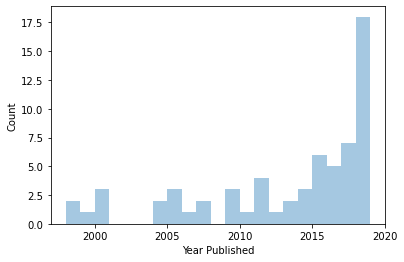

In [34]:
p=sns.distplot(shared2['yrpub'], bins=21, kde=False).set(xlabel='Year Published', ylabel='Count')

In [35]:
#Get a cumulative percent
sharedcumu = shared2.sort_values(by=['yrpub'], ascending=False)
#Reset the index
sharedcumu.reset_index(drop=True,inplace=True)
#Add a count column and calculate cumulative percent (probably a better way to do this)
sharedcumu['count'] = 1
sharedcumu['cumulative']=sharedcumu['count'].cumsum()/sharedcumu['count'].sum()

In [36]:
#Looks like 90% of the books in LFLs and in all of SPL were published 2004 and later. 
sharedcumu.head(60)

,title,yrpub,isbn,age,type,count,cumulative
0,Message from the Shadows: Selected Stories,2019,1939810159,Adult,Fiction,1,0.015625
1,"Waking the Witch: Reflections on Women, Magic,...",2019,1982100702,Adult,Nonfiction,1,0.031250
2,The Moth Presents Occasional Magic: True Stori...,2019,1101904429,Adult,Nonfiction,1,0.046875
3,"Maternal Desire: On Children, Love, and the In...",2019,1501198270,Adult,Nonfiction,1,0.062500
4,Becoming a Restaurateur (Masters at Work),2019,1982103302,Adult,Nonfiction,1,0.078125
5,Feast Your Eyes: A Novel,2019,1501197843,Adult,Fiction,1,0.093750
6,Pretty Revenge,2019,1982122102,Adult,Fiction,1,0.109375
7,#NeverAgain: A New Generation Draws the Line,2018,198480183X,Adult,Nonfiction,1,0.125000
8,Wild Blues,2018,1481491539,Young Adult,Fiction,1,0.140625
9,An Elderly Lady Is Up to No Good,2018,1641290110,Childrens,Fiction,1,0.156250


In [37]:
#Groups by age
sharedage = shared2.groupby(['age'])['count'].count().reset_index() #total of each category
#Sort high to low
sharedage = sharedage.sort_values(by='count', ascending=False).reset_index()
sharedage['percent'] = sharedage['count']/sharedage['count'].sum()
sharedage.head()

,index,age,count,percent
0,0,Adult,47,0.734375
1,1,Childrens,12,0.187500
2,2,Young Adult,5,0.078125


In [38]:
#Groups by type
sharedtype = shared2.groupby(['type'])['count'].count().reset_index() #total of each category
#Sort high to low
sharedtype = sharedtype.sort_values(by='count', ascending=False).reset_index()
sharedtype['percent'] = sharedtype['count']/sharedtype['count'].sum()
sharedtype.head()

,index,type,count,percent
0,0,Fiction,39,0.609375
1,1,Nonfiction,25,0.390625
